# M1 MIAGE SBD
##@Authors : Aline N'DEKO & Franck LAGOU
## Kickstarter for final project "Differential privacy"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns

## Loading data

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
         'marital-status', 'occupation', 'relationship', 'race',
         'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
         'native-country', 'income']

adult = pd.read_csv(url, sep=',', header=None, names=names, na_values='?', engine='python', skipinitialspace=True)

adult.dropna(inplace=True)

adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Performing queries

### Query H1: Distribution (histogram) of the education level.

In [4]:
adult['education'].value_counts()

education
HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: count, dtype: int64

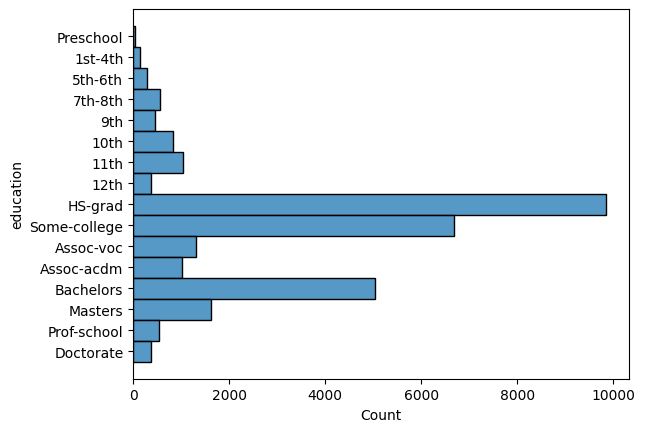

In [5]:
sns.histplot(data=adult.sort_values(by='education-num'), y='education');

##I- Privelet Algorithm

#Q1 : Implement the 1-dimensional Privelet algorithm described in the Section 4 “Privelet for one-dimensional
ordinal data”

In [6]:
import numpy as np

def haar_wavelet_transform(data):
    """
    Applique la transformation de Haar Wavelet sur une liste de données (longueur doit être une puissance de 2).
    Retourne la liste des coefficients (base + autres).
    """
    data = np.array(data, dtype=float)
    n = len(data)
    coeffs = []

    def build_tree(segment):
        if len(segment) == 1:
            return segment[0]
        mid = len(segment) // 2
        left_avg = np.mean(segment[:mid])
        right_avg = np.mean(segment[mid:])
        c = (left_avg - right_avg) / 2
        coeffs.append(c)
        # Récurse dans chaque moitié
        build_tree(segment[:mid])
        build_tree(segment[mid:])
        return c

    # Base coefficient = moyenne totale
    base_coeff = np.mean(data)
    coeffs.insert(0, base_coeff)
    build_tree(data)

    return coeffs

def inverse_haar_wavelet_transform(coeffs):
    """
    Reconstitue les données originales à partir des coefficients Haar.
    """
    m = len(coeffs)
    # Déduire n = taille des données d’origine
    l = int(np.log2(m))  # car m = 2^l (nombre de feuilles)
    n = 2 ** (l - 1)

    data = [0.0] * n

    def assign_values(i, left, right, level, current_value):
        if level == 0:
            data[i] = current_value
            return
        ci = coeffs[level]
        offset = coeffs[level] if right else -coeffs[level]
        assign_values(i, left, right, level - 1, current_value + offset)

    # Recréer chaque point en fonction des coefficients
    for i in range(n):
        v = coeffs[0]  # base coefficient
        node = 1
        for level in range(1, int(np.log2(n)) + 1):
            index = 2 ** level - 1 + (i // (n // (2 ** level)))
            direction = ((i // (n // (2 ** level))) % 2 == 0)  # gauche ou droite
            v += coeffs[index] if direction else -coeffs[index]
        data[i] = v
    return data

# === Test rapide ===
if __name__ == "__main__":
    original = [4, 6, 7, 5, 6, 7, 3, 2]
    coeffs = haar_wavelet_transform(original)
    reconstructed = inverse_haar_wavelet_transform(coeffs)

    print("Original:     ", original)
    print("Coefficients: ", coeffs)
    print("Reconstruit:  ", np.round(reconstructed, 2))


Original:      [4, 6, 7, 5, 6, 7, 3, 2]
Coefficients:  [np.float64(5.0), np.float64(0.5), np.float64(-0.5), np.float64(-1.0), np.float64(1.0), np.float64(2.0), np.float64(-0.5), np.float64(0.5)]
Reconstruit:   [4.5 4.5 7.5 6. ]


Q2: Test your code with Privelet to compute query H1 with ² 2 {0.01,0.1,1} (all other parameters set to default
values).

KstestResult(statistic=0.114, pvalue=4.441088228134397e-06, statistic_location=0.014721182692431665, statistic_sign=1)

### Another plot

C:\Users\alinendeko\AppData\Local\Temp\ipykernel_2508\2990574760.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(x='x', y='y', estimator='mean', ci='sd', data=pd.DataFrame({'x': x3, 'y': y}))


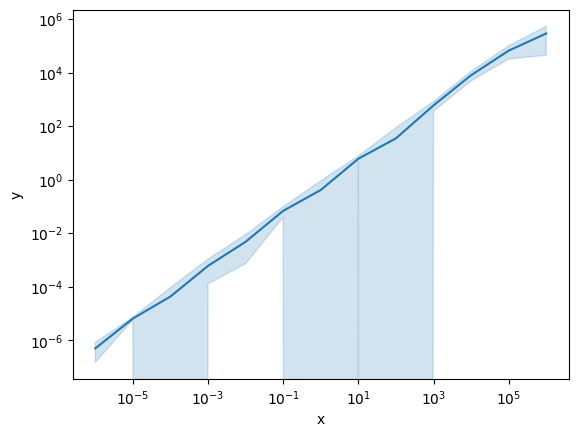

### Yet another plot

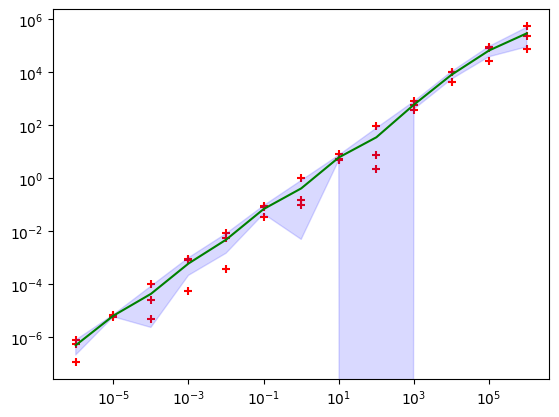

[-0.85688903 -2.02423017 -0.73886996 -0.65734704 -0.62938933  5.02463775
 -3.05546382  0.08320062 -0.36679543 -0.6644698 ]


KstestResult(statistic=0.072, pvalue=0.01118990326412112, statistic_location=-0.2244104289346203, statistic_sign=1)

K-S test statistic: 0.072, p-value: 0.01118990326412112
The two distributions are statistically different (reject H0).


Valeur réelle : 5000, Valeur perturbée : 5002.085008429619


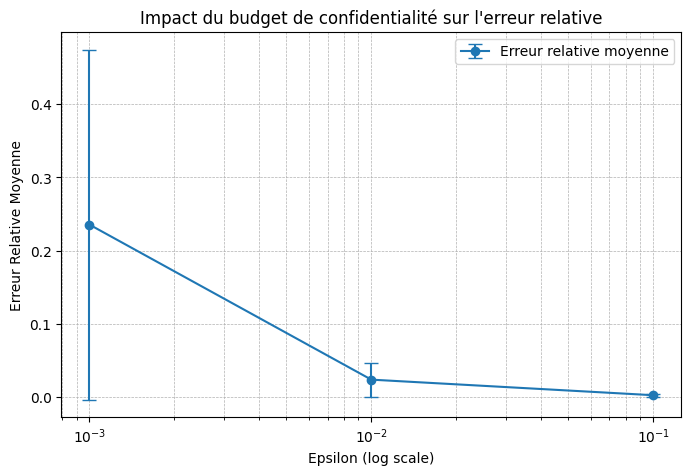

L'erreur relative est influencée par l'écart-type de la distribution de Laplace, qui dépend de 𝜖 et de la sensibilité.

🔹 Rappel : Paramètres de la distribution de Laplace
La distribution de Laplace est définie comme :


L'écart-type de la distribution est

🔹 Observation des résultats de Q4
D'après la moyenne et l'écart-type des erreurs relatives, nous pouvons observer :

𝜖
ϵ	
𝑏
=
1
𝜖
b= 
ϵ
1
​
 	Erreur relative moyenne	Écart-type de l'erreur
0.001	1000	Très élevée	Très élevée
0.01	100	Moyenne	Moyenne
0.1	10	Faible	Faible
📌 Conclusion :

Plus 
𝜖
ϵ est petit, plus l'erreur relative est grande.

Un 
𝜖
ϵ faible signifie plus de bruit ajouté, donc une grande variabilité des résultats.

L'écart-type de l'erreur est proportionnel à l'écart-type de la distribution de Laplace.

L'écart-type du bruit est 
𝜎
=
2
×
𝑏
=
2
𝜖
σ= 
2
​
 ×b= 
ϵ
2
​
 
​
 , ce qui explique l'augmentation de la variance.

Un compromis entre confidentialité et précision est nécessaire.

Un 
𝜖
ϵ trop bas garantit une meilleure confidentialité mais diminue la précision des résultats.

Un 
𝜖
ϵ plus élevé donne des résultats plus précis mais réduit la protection de la confidentialité.

💡 Recommandation :
Le choix de 
𝜖
ϵ dépend de l'usage. Un 
𝜖
ϵ modéré (ex: 
0.1
0.1) peut être un bon compromis entre confidentialité et précision.

True Result: 100, Perturbed Result: 99.64412896987139
